In [1]:
from msresist.figures.common import import_phenotype_data, formatPhenotypesForModeling, plotDistanceToUpstreamKinase
from msresist.figures.figure2 import plotCenters_together, ComputeCenters
from msresist.pre_processing import preprocessing
from msresist.clustering import DDMC
from msresist.plsr import plotStripActualVsPred, plotScoresLoadings
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd

In [2]:
matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [3]:
cv = import_phenotype_data(phenotype="Cell Viability")
red = import_phenotype_data(phenotype="Cell Death")
sw = import_phenotype_data(phenotype="Migration")
c = import_phenotype_data(phenotype="Island")
y = formatPhenotypesForModeling(cv, red, sw, c)
y = y[y["Treatment"] == "A/E"].drop("Treatment", axis=1).set_index("Lines")

In [13]:
# Import siganling data
X = preprocessing(AXLm_ErlAF154=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)
d = X.select_dtypes(include=['float64']).T
i = X.select_dtypes(include=['object'])

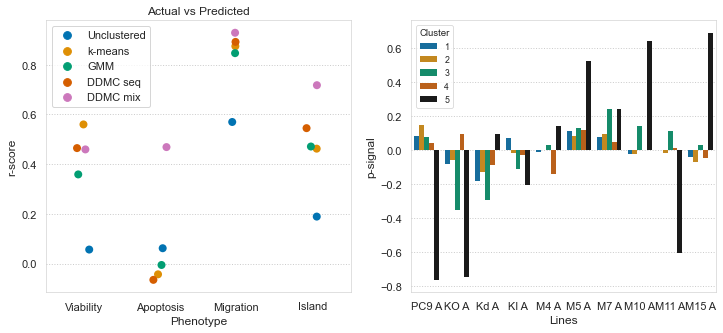

In [5]:
# Fit DDMC
# 5-2-2
ddmc = DDMC(i, n_components=5, SeqWeight=2, distance_method="PAM250", random_state=5) 
Xs, models = ComputeCenters(X, d, i, ddmc)

_, ax = plt.subplots(1, 2, figsize=(12, 5))
plotStripActualVsPred(ax[0], [2, 2, 2, 2, 2], Xs, y, models, size=8)
ax[0].legend(loc="upper left")
plotCenters_together(ddmc, X, ax[1], drop=None)
# plt.savefig("newfigs.svg")

In [6]:
import numpy as np
import pandas as pd

for ii in range(ddmc.n_components):
    cl_idx = [i for i in range(len(ddmc.labels())) if ddmc.labels()[i] == ii + 1]
    print(np.mean(ddmc.scores_[cl_idx, ii]))

pd.DataFrame(ddmc.scores_).mean()

0.9624689221787543
0.9296579425461545
0.9485894830682385
0.9058481984610186
0.9809570803223266


0    0.039902
1    0.376243
2    0.318983
3    0.168334
4    0.096538
dtype: float64

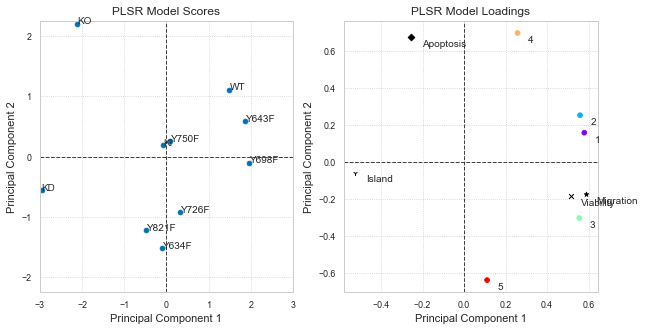

In [7]:
# Scores & Loadings
lines = ["WT", "KO", "KD", "KI", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F ", "Y821F"]
plsr = PLSRegression(n_components=2, scale=True)
centers = ddmc.transform()

_, ax = plt.subplots(1, 2, figsize=(10, 5))
plotScoresLoadings(ax, plsr.fit(centers, y), centers, y, ddmc.n_components, lines, pcX=1, pcY=2)

/Users/creixell/Desktop/UCLA/Projects/UO1/Computational/GitHub.tmp/AXLomics/msresist/clustering.py:172: RuntimeWarning: invalid value encountered in true_divide
  pssm /= back_pssm.copy()
/Users/creixell/Desktop/UCLA/Projects/UO1/Computational/GitHub.tmp/AXLomics/msresist/clustering.py:188: RuntimeWarning: divide by zero encountered in log2
  pssm.loc[p_site, 5] = np.log2(clSeq.loc[p_site, 5] / tm)
/Users/creixell/Desktop/UCLA/Projects/UO1/Computational/GitHub.tmp/AXLomics/msresist/clustering.py:172: RuntimeWarning: invalid value encountered in true_divide
  pssm /= back_pssm.copy()
/Users/creixell/Desktop/UCLA/Projects/UO1/Computational/GitHub.tmp/AXLomics/msresist/clustering.py:188: RuntimeWarning: divide by zero encountered in log2
  pssm.loc[p_site, 5] = np.log2(clSeq.loc[p_site, 5] / tm)
No handles with labels found to put in legend.


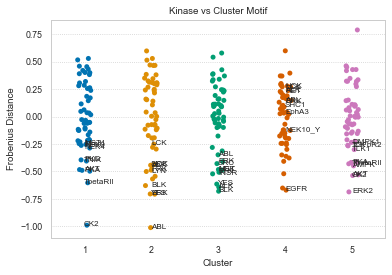

In [67]:
# Plot upstream kinases heatmap
_, ax = plt.subplots(1, 1)
plotDistanceToUpstreamKinase(ddmc, [1, 2, 3, 4, 5], ax, num_hits=10, PsP_background=True)

In [76]:
list(ddmc.labels()).count(4)

71

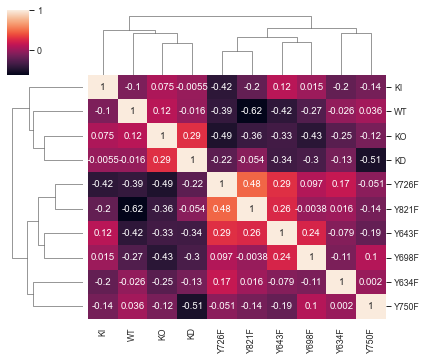

In [9]:
d.index = ["WT", "KO", "KD", "KI", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F", "Y821F"]
sns.clustermap(d.T.corr(), figsize=(6, 5), mask=False, annot=True)

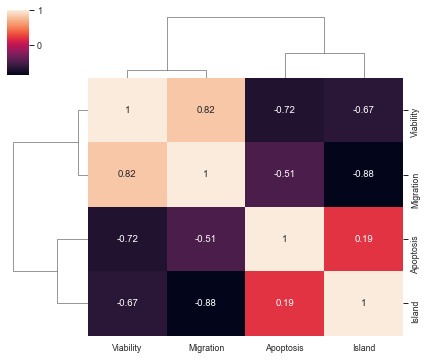

In [10]:
sns.clustermap(y.corr(), figsize=(6, 5), mask=False, annot=True)

In [11]:
from msresist.pre_processing import Linear
import numpy as np

xL = Linear(X, X.columns[7:])
xL.insert(7, "WTvsKO", np.log2((xL["PC9 A"] / xL["KO A"]).values))
xL["Position"] = [s.replace("-p", "").replace(";", "/") for s in xL["Position"]]

ddmc.store_cluster_members(xL, "DDMC_PAM250_5Cl_W2_RS5_C", ["UniprotAcc", "Gene", "Sequence", "Position", "WTvsKO"])

In [13]:
X[X["Gene"] == "ABL1"]

,Protein,Sequence,UniprotAcc,Position,BioReps,r2_Std,Gene,WTvsKO,PC9 A,KO A,Kd A,KI A,M4 A,M5 A,M7 A,M10 A,M11 A,M15 A,Cluster
527,Tyrosine-protein kinase ABL1,SDGKLyVSSES,P00519,Y185,1,N/A,ABL1,0.256547,1.127644,0.943938,1.124336,1.319636,0.793589,0.775117,0.902566,0.939591,1.211179,1.00218,2


In [15]:
Xer = preprocessing(AXLm_Erl=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)
Xer

TypeError: preprocessing() got an unexpected keyword argument 'AXLm_Erl'

In [10]:
from msresist.gsea import translate_geneIDs

x_gsea = translate_geneIDs(X, ddmc.labels(), toID="entrezgene", export=True, outpath="AXL_GSEA_Input.csv")

querying 1-491...done.
Finished.
109 input query terms found dup hits:
	[('TNKS1BP1', 2), ('RPS10', 2), ('GIT1', 2), ('AFAP1L2', 4), ('ACTB', 5), ('TNK2', 5), ('ALB', 2), (
9 input query terms found no hit:
	['NARS', 'MPP5', 'MPP5', 'SEPT2', 'SEPT2', 'ICK', 'ICK', 'ICK', 'TARS']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


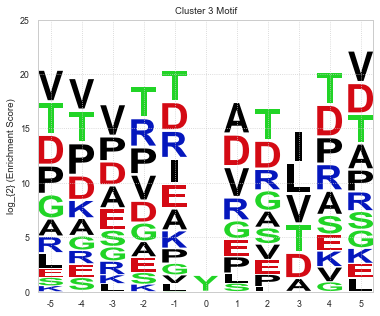

In [66]:
from msresist.figures.figureS5 import plotMotifs

pssms, _ = ddmc.pssms(PsP_background=True)

_, ax = plt.subplots(1, 1, figsize=(6, 5))
plotMotifs([pssms[2]], axes=[ax], titles=["Cluster 3"], yaxis=[0, 25])
plt.savefig("logoCL3.svg")

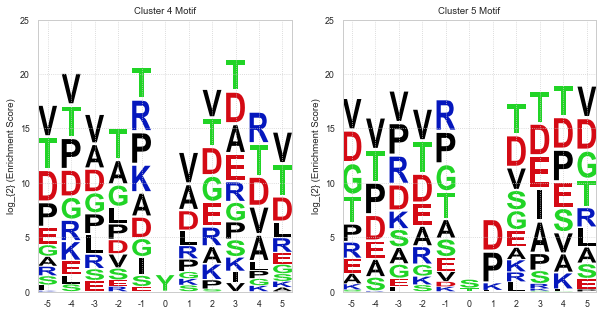

In [61]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
plotMotifs([pssms[3], pssms[4]], axes=ax, titles=["Cluster 4", "Cluster 5"], yaxis=[0, 25])

In [56]:
from msresist.motifs import PSPLdict

def plotPSPL(kinase, aa, ax):
    PSPLs = PSPLdict()
    kin = pd.DataFrame(PSPLs[kinase])
    kin.index = aa
    plotMotifs([kin], axes=[ax], titles=[kinase], yaxis=[0, 6])

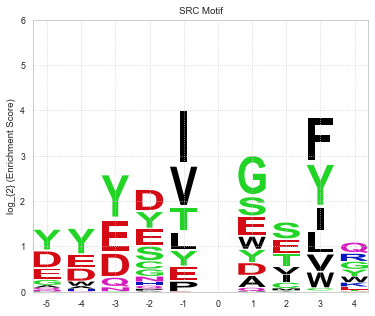

In [57]:
_, ax = plt.subplots(1, 1, figsize=(6, 5))
plotPSPL("SRC", pssms[0].index, ax)

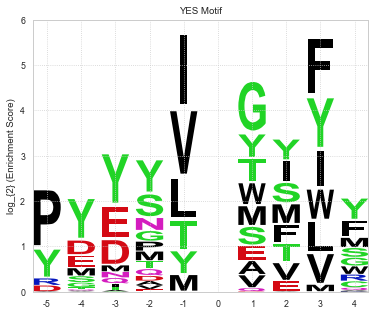

In [58]:
_, ax = plt.subplots(1, 1, figsize=(6, 5))
plotPSPL("YES", pssms[0].index, ax)

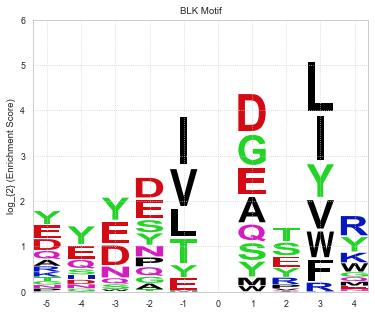

In [59]:
_, ax = plt.subplots(1, 1, figsize=(6, 5))
plotPSPL("BLK", pssms[0].index, ax)

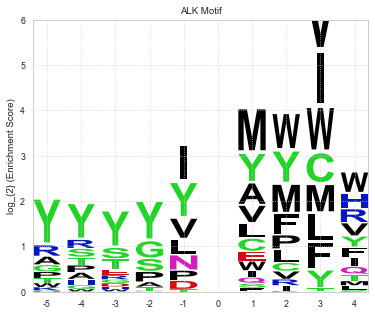

In [60]:
_, ax = plt.subplots(1, 1, figsize=(6, 5))
plotPSPL("ALK", pssms[0].index, ax)